#  A/B testing for the online store

# Project Description

The goal of the project is to prioritize a list of compiled hypotheses, launch an A/B test, and analyze the results in order to
to help boost revenue of a big online store. 

**Available data:**

- The file hypotheses_us.csv contains nine hypotheses on boosting an online store's revenue with Reach, Impact,   Confidence, and Effort specified for each.
- The results of the A/B test described in the files orders_us.csv and visits_us.csv.

##  Data preprocessing

### Import libraries

In [1]:
home = %pwd
print(home)
if home != 'C:/Users/Coami':
    
    !pip install -Uq matplotlib --user
    !pip install -Uq numpy --user
    !pip install -Uq pandas --user
    !pip install -Uq plotly --user
    
    !pip install -Uq seaborn --user
    !pip install -Uq sidetable --user
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\Users\Sophie\Personal_proj


In [2]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import datetime
import random
   # !pip install -Uq seaborn --user
    #!pip install -Uq plotly --user
   # !pip install plotly
   # !pip install -Uq plotly --user
import sys
    #!conda install --yes --prefix {sys.prefix} plotly
import plotly as px
import plotly.express as px
import scipy.stats as stats

### Import data

In [5]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep='\;',)
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv',sep='\;')

hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
hypotheses = hypotheses.rename(columns=str.lower)
hypotheses['hypothesis_id']=[1,2,3,4,5,6,7,8,9]
hypotheses

,hypothesis,reach,impact,confidence,effort,hypothesis_id
0,Add two new channels for attracting traffic. T...,3,10,8,6,1
1,Launch your own delivery service. This will sh...,2,5,4,10,2
2,Add product recommendation blocks to the store...,8,3,7,3,3
3,Change the category structure. This will incre...,8,3,3,8,4
4,Change the background color on the main page. ...,3,1,1,1,5
5,Add a customer review page. This will increase...,3,2,2,3,6
6,Show banners with current offers and sales on ...,5,3,8,3,7
7,Add a subscription form to all the main pages....,10,7,8,5,8
8,Launch a promotion that gives users discounts ...,1,9,9,5,9


In [7]:
try:
    orders = pd.read_csv('orders_us.csv',
    parse_dates=['date'])
                         #, sep='\;',)
except:
    orders = pd.read_csv('/datasets/orders_us.csv',
    parse_dates=['date'])
                         #',sep='\;')
orders = orders.rename(columns=str.lower)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [8]:
try:
    visits = pd.read_csv('visits_us.csv',
    parse_dates=['date'])
                         #, sep='\;',)
except:
    visits = pd.read_csv('/datasets/visits_us.csv',
    parse_dates=['date'])
                         #',sep='\;')

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Checking mistakes in the original datasets

In [9]:
print(len(orders.query('group == "A"')['visitorid'].unique()) 
      +len(orders.query('group == "B"')['visitorid'].unique()) 
      -orders['visitorid'].nunique())

58


Keeping the visitors that were assigned to both groups might disturb the results. It is safer to drop it.

In [10]:
drop_list=list(set(orders.query('group == "A"')['visitorid'].unique()) & set(orders.query('group == "B"')['visitorid'].unique()))
orders = orders[~orders.visitorid.isin(drop_list)].reset_index()
orders

,index,transactionid,visitorid,date,revenue,group
0,0,3667963787,3312258926,2019-08-15,30.4,B
1,1,2804400009,3642806036,2019-08-15,15.2,B
2,3,3797467345,1196621759,2019-08-15,155.1,B
3,4,2282983706,2322279887,2019-08-15,40.5,B
4,5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...,...
1011,1191,3592955527,608641596,2019-08-14,255.7,B
1012,1192,2662137336,3733762160,2019-08-14,100.8,B
1013,1193,2203539145,370388673,2019-08-14,50.1,A
1014,1194,1807773912,573423106,2019-08-14,165.3,A


In [11]:
len(list(set(orders.query('group == "A"')['visitorid'].unique()) & set(orders.query('group == "B"')['visitorid'].unique())))

0

## Prioritizing Hypotheses

### ICE

In [12]:
hypotheses['ICE']= (hypotheses['impact']*hypotheses['confidence']/hypotheses['effort']).round()
print(hypotheses[['hypothesis_id','ICE']].sort_values(by='ICE', ascending = False))

   hypothesis_id   ICE
8              9  16.0
0              1  13.0
7              8  11.0
6              7   8.0
2              3   7.0
1              2   2.0
3              4   1.0
4              5   1.0
5              6   1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


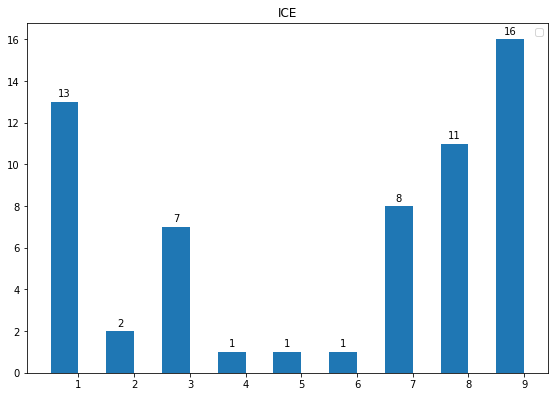

In [13]:
x = np.arange(len(hypotheses['hypothesis_id']))  # the label locations
width = 0.5  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, hypotheses['ICE'], width) #, label='ICE')
#rects2 = ax.bar(x + width/2, hypotheses['RICE'], width, label='RICE')

ax.set_title('ICE')
ax.set_xticks(x, hypotheses['hypothesis_id'])
ax.legend()
ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(8)

plt.show()

The most promising hypotheses according to ICE are number 9, 1 and 8. 

### RICE

In [14]:
hypotheses['RICE']= hypotheses['reach']*hypotheses['impact']*hypotheses['confidence']/hypotheses['effort']
print(hypotheses[['hypothesis_id','RICE']].sort_values(by='RICE', ascending = False))

   hypothesis_id   RICE
7              8  112.0
2              3   56.0
0              1   40.0
6              7   40.0
8              9   16.2
3              4    9.0
1              2    4.0
5              6    4.0
4              5    3.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


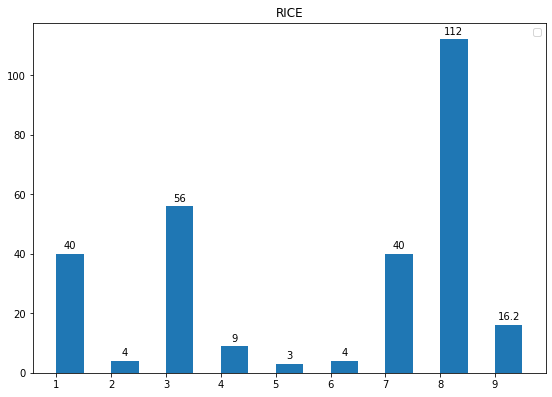

In [15]:
x = np.arange(len(hypotheses['hypothesis_id']))  # the label locations
width = 0.5  # the width of the bars
fig, ax = plt.subplots()
#rects1 = ax.bar(x - width/2, hypotheses['ICE'], width, label='ICE')
rects2 = ax.bar(x + width/2, hypotheses['RICE'], width)#, label='RICE')

ax.set_title('RICE')
ax.set_xticks(x, hypotheses['hypothesis_id'])
ax.legend()
#ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(8)

plt.show()

The most promising hypotheses according to RICE are number 8, 3, 1 and 7. And number 8 has significantly more potential.

### Prioritization methods comparison 

After applying ICE framework we would consider hypotheses 9, 1, 8, 7, 3 to be the most promising ones. But after taking into account how many users they would affect we would get that number 8 hypotheses is the most promising. After that, we can also take into account hypotheses 1,3 and 7 and dismiss hypotheses 9 since it won't affect a lot of users compared to the others.

## A/B Test Analysis

### Cumulative revenue by group

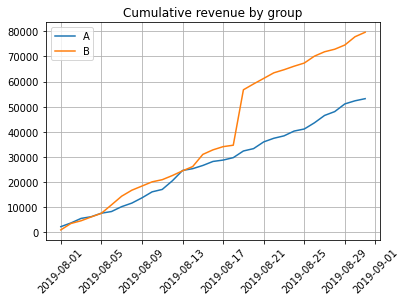

In [16]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionid': pd.Series.nunique,
            'visitorid': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


# DataFrame with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Plotting the group A revenue graph 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Plotting the group B revenue graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Cumulative revenue by group')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

Cumulative revenue for the two groups looked the same at the beginning. Between 17-08-2019 and 21-08-2019 revenue of the B group significantly increased and remained at a higher level. It seems like we have an abnormality within the data we need to get rid of. 

### Cumulative average order size by group

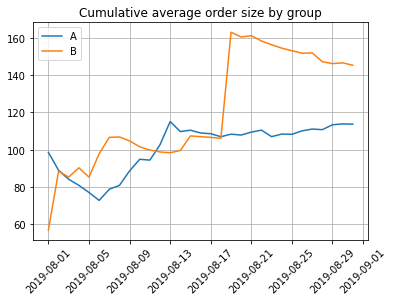

In [17]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Cumulative average order size by group')
plt.legend() 
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

The data seems to be unstable, falling and rising abnormally. We need to pay attention to the possible outliers. 

###  Relative difference in cumulative average order size for groups

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


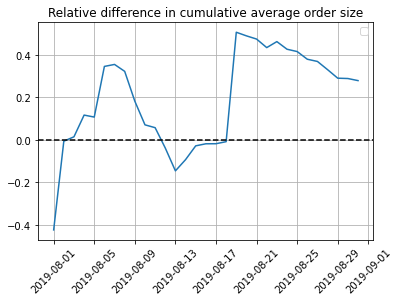

In [18]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Relative difference in cumulative average order size')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()


Relative difference shows us there were several significant changes. Probably due to the disturbance within the data we've suspected earlier.

### Group's conversion rate

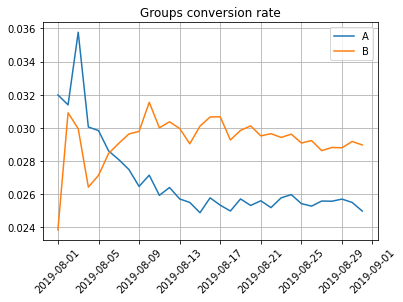

In [19]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# selecting data on group A 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# selecting data on group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plotting the graphs
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Groups conversion rate')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

Group A had a higher level of conversion at the beginning, group B had a rise later and managed to stay at a certain level of conversion.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


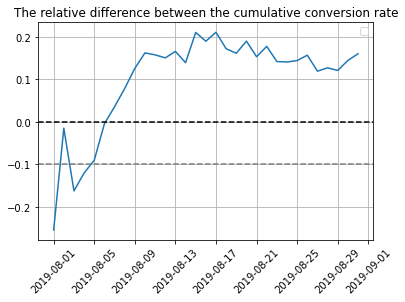

In [20]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('The relative difference between the cumulative conversion rate')
plt.xticks(rotation=45)
plt.grid()
plt.show()

The group B is leading in conversion rate, but we can't see it stabilizing at any certain level.

### Number of orders per user

In [21]:
orders

,index,transactionid,visitorid,date,revenue,group
0,0,3667963787,3312258926,2019-08-15,30.4,B
1,1,2804400009,3642806036,2019-08-15,15.2,B
2,3,3797467345,1196621759,2019-08-15,155.1,B
3,4,2282983706,2322279887,2019-08-15,40.5,B
4,5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...,...
1011,1191,3592955527,608641596,2019-08-14,255.7,B
1012,1192,2662137336,3733762160,2019-08-14,100.8,B
1013,1193,2203539145,370388673,2019-08-14,50.1,A
1014,1194,1807773912,573423106,2019-08-14,165.3,A


In [22]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorid', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False))


      visitorid  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
..          ...     ...
331  1438226485       1
332  1452540367       1
333  1455323168       1
334  1455861274       1
972  4283872382       1

[973 rows x 2 columns]


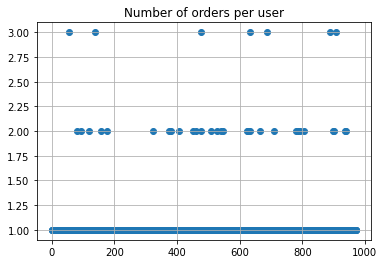

In [23]:
# the range of numbers from 0 to the number of observations in ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Number of orders per user')

plt.grid()

plt.show()

Most of the users made only one purchase, it is rare for a user to make two purchases and even more rare to make 3. It could be outliers.

###  The 95th and 99th percentiles for the number of orders per user

In [24]:
print('The 95th and 99th percentiles for the number of orders per user:', np.percentile(ordersByUsers['orders'], [95, 99])) 

The 95th and 99th percentiles for the number of orders per user: [1. 2.]


No more than 5 % of the users had more than 1 order and only 1 % had more than 2. Therefore 1 or 2 should be used as defining for cutting off the anomalies.

### Order prices

Text(0.5, 1.0, 'Order prices')

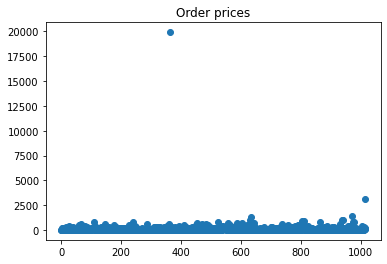

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Order prices')

Most of the orders do not reach value of 2500. And an order of 20000 can be considered as anomaly.

###  The 95th and 99th percentiles of order prices

In [26]:
print('The 95th and 99th percentiles of order prices:', np.percentile(orders['revenue'], [95, 99])) 

The 95th and 99th percentiles of order prices: [414.275 830.3  ]


No more of 5% of the orders cost more then 414 and no more then 1$ cost more then 830. Anything more than that can be considered as anomaly.

### Statistical significance of the difference in conversion between the groups based on the raw data

To calculate the statistical significance of the difference in conversion between the groups we will apply the Mann-Whitney test.

The null-hypothesis, Ho: The conversion rate of group A is the same as conversion rate of group B.

H1 hypothesis: There is a statistically significant difference in conversion rate between groups A and B.

In [27]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorid', 'orders'] 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits [visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits [visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

print('p-value to compare the groups conversion:',"{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('The relative difference in conversion between the groups:',"{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 


p-value to compare the groups conversion: 0.01102
The relative difference in conversion between the groups: 0.160


The p-value is considerably lower than 0.05 so we reject the null hypothesis. The raw data analysis showed that the groups' conversion rates have statistically significant differences.

The relative conversion gain for group B compared with group A is 16%.

### The statistical significance of the difference in average order size between the groups based on the raw data

The null-hypothesis, Ho: The average order size doesn't differ between the groups A and B.

H1 hypothesis: There is a statistically significant difference in average order size between groups A and B.

In [28]:
print('p-value to compare the groups average order size:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('The relative gain for group B:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value to compare the groups average order size: 0.862
The relative gain for group B: 0.278


The p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis and we can't conclude that average order size differs between the groups. 

Nonetheless, the average order size for group A is much smaller than it is for group B. (27.8%)

### The statistical significance of the difference in conversion between the groups based on the filtered data

Let's define anomalous users as those who place more than 1 order or one order bigger than 600. Thus we'll remove the 5% of users with the largest numbers of orders and from 1% to 5% of the users with the most expensive orders. Let's make data slices with the users who placed more than 1 order (usersWithManyOrders) and the users who placed orders for more than 600 (usersWithExpensiveOrders). We'll join them in a table called abnormalUsers.

In [29]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['visitorid'], ordersByUsersB[ordersByUsersB['orders'] > 1]['visitorid']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 600]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

937    148427295
33     249864742
586    358944393
36     366673373
557    382846391
Name: visitorid, dtype: int64
(59,)


We have 59 anomalous users in total.
Let's try to find out how their actions affected the test results. We'll calculate the statistical significance of the differences in conversion between the groups, using filtered data. First we'll prepare samples of the number of orders per user for each test group. Then we will apply the statistical Mann-Whitney criterion to the resulting samples:

The null-hypothesis, Ho: The conversion rate of group A is the same as conversion rate of group B for filtered data.

H1 hypothesis: There is a statistically significant difference in conversion rate between groups A and B for filtered data.

In [30]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)
print('p-value to compare the groups conversion:',"{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('The relative difference in conversion between the groups:',"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value to compare the groups conversion: 0.00632
The relative difference in conversion between the groups: 0.196


The filtered data analysis showed that the groups' conversion rates have statistically significant differences.

The relative conversion gain for group B compared with group A is 19.6% now.

The results for conversion almost didn't change.

### The statistical significance of the difference in average order size between the groups based on the filtered data

The null-hypothesis, Ho: The average order size doesn't differ between the groups A and B for filtered data.

H1 hypothesis: There is a statistically significant difference in average order size between groups A and B for filtered data.

In [31]:
print('p-value to compare the groups average order size:','{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print('The relative gain for group B:','{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

p-value to compare the groups average order size: 0.834
The relative gain for group B: 0.061


We can't resume that the average order size differ between the groups for a test based on filtered data. 

The average order size for group B is now only a little bit more than for the group A (6.1%).

## Conclusion

- There's a statistically significant difference in conversion between the groups, according to both the raw and the filtered data.
- The raw data didn't show a statistically significant difference between the groups in terms of average purchase size. However, after the anomalies were removed, it turned out that they indeed strongly affected the relative gain in average purchase size for B group.

The recommended decision is to stop the test. The results of group B can be considered better compared to group A.